# From data lake to data warehouse

Disclaimer:
- Link to the AWS academy login: https://awsacademy.instructure.com/login/canvas
- At the end of the lab, remember to Stop/Destroy the created services. (Why?)
- These slides are directly generated from the notebook (this notebook = slides)
- Upload the Notebook to Sagemaker (not in COLAB!)
- The second part of the lab requires [Tableau Desktop](https://www.tableau.com/products/desktop/download) installed on your machine

Known issues:
- AWS classroom does not work on *Safari*. Solution: choose another browser
- Tableau Desktop had problems on *macOS* when connecting to Postgres. Solution: use the lab's computer

A data warehouse and a data lake serve different needs and use cases.

A data lake stores relational data from business applications, and non-relational data 
- The structure of the data or schema is not defined when data is captured
- You can store all of your data without careful design or the need to know what questions you might need answers 

A data warehouse is a database optimized to analyze relational data coming from business applications
- The data structure and schema are defined in advance to optimize for fast SQL queries
- The results are typically used for operational reporting and analysis
- Data is cleaned, enriched, and transformed so it can act as the single source of truth

Organizations are evolving their warehouse to include data lakes, and enable diverse query capabilities

**Goal**: build a sub-module of the expert system, namely a DWH to monitor historical trends of soil moisture

Necessary steps:

1. Create a data lake (AWS S3)
2. Collect and store the sensor data (manually)
   - KISS: we start with a .csv with sensor data
3. Do ETL (AWS SageMaker and/or AWS Glue)
4. Build a (relational) data warehouse (AWS RDS)
5. Query the data warehouse (Tableau)

## 1. Create a data lake

See the AWS console
- https://awsacademy.instructure.com/login/canvas

![image](https://user-images.githubusercontent.com/18005592/200340672-756adacd-bad6-4aca-b7ca-8c03ff20d928.png)


![image](https://user-images.githubusercontent.com/18005592/200342442-edaa7560-95a2-47d1-b6b2-ccc4ae9abe0c.png)

Start the lab

![image](https://user-images.githubusercontent.com/18005592/200342733-326a05b7-9f6e-438f-9749-1322412d7321.png)

When AWS is green, click on it

![image](https://user-images.githubusercontent.com/18005592/200343321-444d3d2b-3e95-4296-baaa-29cf10616736.png)

![image](https://user-images.githubusercontent.com/18005592/200344531-88e92bbb-c0c0-456e-a532-a116d8d330f4.png)

AWS Simple Storage Service (S3) 
- A serverless object storage service offering industry-leading scalability, data availability, security, and performance. 
- Customers of all sizes and industries can store and protect any amount of data for virtually any use case, such as data lakes


Create two buckets:

In [1]:
input_bucket = "s3://landing-raw-wateringsensors-1234/"
output_bucket = "s3://staging-clean-wateringsensors-12345/"

![image](https://user-images.githubusercontent.com/18005592/200345832-d3522fdb-92ee-4457-8a78-5c0449af6bc4.png)

![image](https://user-images.githubusercontent.com/18005592/200346937-410c49dc-6685-447c-9b18-4970f1954e6c.png)

In [2]:
input_bucket = "s3://landing-raw-wateringsensors-1234/"
output_bucket = "s3://staging-clean-wateringsensors-12345/"

## 2. Collect and store the sensor data (manually)

We need a working environment.

Amazon SageMaker
- Fully managed service that provides machine learning (ML) capabilities for data scientists and developers to prepare, build, train, and deploy high-quality ML models efficiently

KISS: we start with a .csv with sensor data
- http://big.csr.unibo.it/projects/nosql-datasets/watering-data-1661269649253.csv

![image](https://user-images.githubusercontent.com/18005592/200364098-6390f3a4-e1cf-4041-9d88-ab425ed9933b.png)

![image](https://user-images.githubusercontent.com/18005592/200364480-53d6fe54-aac6-431c-a664-87712f82d2cf.png)

![image](https://user-images.githubusercontent.com/18005592/200364714-37992354-a047-440e-bfe3-12df1e1264ad.png)

![image](https://user-images.githubusercontent.com/18005592/200364905-e6b7f5b6-ee52-4e8e-9df3-b2e8b9b5afb0.png)

![image](https://user-images.githubusercontent.com/18005592/200365269-0b85f661-a0c8-4902-9c93-eb978b5226bd.png)

In [3]:
!pip install awswrangler==3.4.2
!pip install pandas==2.1.2
!pip install scikit-learn==1.3.0
!pip install seaborn==0.12.2
import warnings
warnings.filterwarnings('ignore')

In [4]:
import awswrangler as wr
import pandas as pd
file_name = "watering-data-1661269649253.csv"  # name of the dataset
df = pd.read_csv("http://big.csr.unibo.it/projects/nosql-datasets/" + file_name)  # import the dataset from unibo's server
wr.s3.to_csv(df, path=input_bucket + file_name)  # write it to the data lake

{'paths': ['s3://landing-raw-wateringsensors-1234/watering-data-1661269649253.csv'],
 'partitions_values': {}}

## 3. Do ETL (AWS SageMaker)

In [5]:
# import the data
print(input_bucket + file_name)
df = wr.s3.read_csv(input_bucket + file_name)
df

s3://landing-raw-wateringsensors-1234/watering-data-1661269649253.csv


,Unnamed: 0,plantRow,detectedValueTypeId,yy,xx,value,unit,timestamp,zz
0,0,T1 basso,GRND_WATER_G,-20.0,25.0,-21.616472,cbar,1628951453,NaN
1,1,T1 basso,GRND_WATER_G,-20.0,50.0,-113.354793,cbar,1628950550,NaN
2,2,T1 basso,GRND_WATER_G,-20.0,0.0,-21.041212,cbar,1628947848,0.0
3,3,T1 basso,GRND_WATER_G,-20.0,0.0,-21.328847,cbar,1628948747,0.0
4,4,T1 basso,GRND_WATER_G,-20.0,25.0,-130.458021,cbar,1628657108,NaN
...,...,...,...,...,...,...,...,...,...
29059,29059,T1 basso,GRND_WATER_G,-60.0,0.0,-74.186077,cbar,1627102804,0.0
29060,29060,T1 basso,GRND_WATER_G,-60.0,25.0,-209.033680,cbar,1627101007,NaN
29061,29061,T1 basso,GRND_WATER_G,-60.0,50.0,-352.458317,cbar,1627101905,NaN
29062,29062,T1 basso,GRND_WATER_G,-60.0,50.0,-352.458317,cbar,1627101007,NaN


Data understanding

- `plantRow`: name of the field in which we have the sensors
- `detectedValueTypeId`: type of the sensor data
- `xx`, `yy`, and `zz`: displacement of the sensor with respect to the dripper
- `value`: measurement
- `unit`: unit of measurement
- `timestamp`: when the measurement has been recorded

Data profiling

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,29064.0,1.453150e+04,8390.198448,0.000000e+00,7.265750e+03,1.453150e+04,2.179725e+04,2.906300e+04
yy,28512.0,-4.240741e+01,16.099585,-6.000000e+01,-6.000000e+01,-4.000000e+01,-2.000000e+01,-2.000000e+01
xx,28512.0,3.875000e+01,29.660046,0.000000e+00,1.875000e+01,3.750000e+01,5.750000e+01,8.000000e+01
value,29064.0,-1.821906e+02,506.803601,-9.885007e+02,-3.890425e+02,-1.446921e+02,-2.430051e+01,3.641000e+03
timestamp,29064.0,1.627720e+09,757387.611829,1.626307e+09,1.627103e+09,1.627749e+09,1.628371e+09,1.628985e+09
zz,14256.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29064 entries, 0 to 29063
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           29064 non-null  int64  
 1   plantRow             29064 non-null  object 
 2   detectedValueTypeId  29064 non-null  object 
 3   yy                   28512 non-null  float64
 4   xx                   28512 non-null  float64
 5   value                29064 non-null  float64
 6   unit                 29064 non-null  object 
 7   timestamp            29064 non-null  int64  
 8   zz                   14256 non-null  float64
dtypes: float64(4), int64(2), object(3)
memory usage: 2.0+ MB


Data distribution

In [8]:
import math
import matplotlib.pyplot as plt

def plot(df):
    cols = 5
    rows = math.ceil(len(df.columns) / cols)

    fig, axs = fig, ax = plt.subplots(rows, cols, figsize = (3 * cols, 2 * rows))
    i = 0

    for x in df.columns:
        ax = axs[int(i / cols)][i % cols]
        # df[x].value_counts().plot(kind="bar", ax=ax)
        df[x].hist(ax=ax)
        ax.set_title(x)
        i += 1
    
    fig.tight_layout()

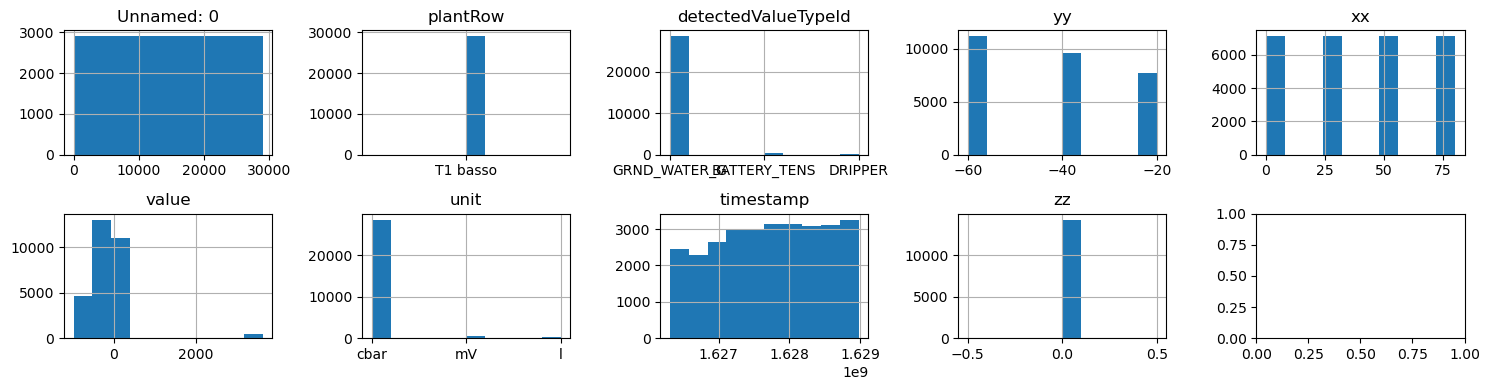

In [9]:
plot(df)

The `zz` column contains missing values and a single non-null value (`0`), what should we do?

In [10]:
if "zz" in df.columns:
    df = df.drop(columns=["zz"])
df

,Unnamed: 0,plantRow,detectedValueTypeId,yy,xx,value,unit,timestamp
0,0,T1 basso,GRND_WATER_G,-20.0,25.0,-21.616472,cbar,1628951453
1,1,T1 basso,GRND_WATER_G,-20.0,50.0,-113.354793,cbar,1628950550
2,2,T1 basso,GRND_WATER_G,-20.0,0.0,-21.041212,cbar,1628947848
3,3,T1 basso,GRND_WATER_G,-20.0,0.0,-21.328847,cbar,1628948747
4,4,T1 basso,GRND_WATER_G,-20.0,25.0,-130.458021,cbar,1628657108
...,...,...,...,...,...,...,...,...
29059,29059,T1 basso,GRND_WATER_G,-60.0,0.0,-74.186077,cbar,1627102804
29060,29060,T1 basso,GRND_WATER_G,-60.0,25.0,-209.033680,cbar,1627101007
29061,29061,T1 basso,GRND_WATER_G,-60.0,50.0,-352.458317,cbar,1627101905
29062,29062,T1 basso,GRND_WATER_G,-60.0,50.0,-352.458317,cbar,1627101007


In [11]:
df.groupby(["xx", "yy"])["timestamp"].count()

xx    yy   
0.0   -60.0    2790
      -40.0    2406
      -20.0    1932
25.0  -60.0    2790
      -40.0    2406
      -20.0    1932
50.0  -60.0    2790
      -40.0    2406
      -20.0    1932
80.0  -60.0    2790
      -40.0    2406
      -20.0    1932
Name: timestamp, dtype: int64

In [12]:
df.groupby(["yy", "xx"])["timestamp"].count()

yy     xx  
-60.0  0.0     2790
       25.0    2790
       50.0    2790
       80.0    2790
-40.0  0.0     2406
       25.0    2406
       50.0    2406
       80.0    2406
-20.0  0.0     1932
       25.0    1932
       50.0    1932
       80.0    1932
Name: timestamp, dtype: int64

What else can we do?

- Do we need to store the `plantRow`?
- Do the sensors from the same `detectedValueTypeId` share the same `unit`?
- Do we care about all the sensor types (i.e., `detectedValueTypeId`)?

In [13]:
df.groupby(["detectedValueTypeId"]).nunique()

,Unnamed: 0,plantRow,yy,xx,value,unit,timestamp
detectedValueTypeId,,,,,,,
BATTERY_TENS,399,1,0,0,7,1,391
DRIPPER,153,1,0,0,34,1,153
GRND_WATER_G,28512,1,3,4,2362,1,6668


Drop the "useless" columns

In [14]:
# What should we drop?
# df = df.drop(["plantRow", "unit"], axis=1)
df

,Unnamed: 0,plantRow,detectedValueTypeId,yy,xx,value,unit,timestamp
0,0,T1 basso,GRND_WATER_G,-20.0,25.0,-21.616472,cbar,1628951453
1,1,T1 basso,GRND_WATER_G,-20.0,50.0,-113.354793,cbar,1628950550
2,2,T1 basso,GRND_WATER_G,-20.0,0.0,-21.041212,cbar,1628947848
3,3,T1 basso,GRND_WATER_G,-20.0,0.0,-21.328847,cbar,1628948747
4,4,T1 basso,GRND_WATER_G,-20.0,25.0,-130.458021,cbar,1628657108
...,...,...,...,...,...,...,...,...
29059,29059,T1 basso,GRND_WATER_G,-60.0,0.0,-74.186077,cbar,1627102804
29060,29060,T1 basso,GRND_WATER_G,-60.0,25.0,-209.033680,cbar,1627101007
29061,29061,T1 basso,GRND_WATER_G,-60.0,50.0,-352.458317,cbar,1627101905
29062,29062,T1 basso,GRND_WATER_G,-60.0,50.0,-352.458317,cbar,1627101007


Drop the useless rows

In [15]:
df = df[df["detectedValueTypeId"] == "GRND_WATER_G"]
df = df.drop(["detectedValueTypeId"], axis=1)
df

,Unnamed: 0,plantRow,yy,xx,value,unit,timestamp
0,0,T1 basso,-20.0,25.0,-21.616472,cbar,1628951453
1,1,T1 basso,-20.0,50.0,-113.354793,cbar,1628950550
2,2,T1 basso,-20.0,0.0,-21.041212,cbar,1628947848
3,3,T1 basso,-20.0,0.0,-21.328847,cbar,1628948747
4,4,T1 basso,-20.0,25.0,-130.458021,cbar,1628657108
...,...,...,...,...,...,...,...
29059,29059,T1 basso,-60.0,0.0,-74.186077,cbar,1627102804
29060,29060,T1 basso,-60.0,25.0,-209.033680,cbar,1627101007
29061,29061,T1 basso,-60.0,50.0,-352.458317,cbar,1627101905
29062,29062,T1 basso,-60.0,50.0,-352.458317,cbar,1627101007


Take a better look at the sensor data over time

In [16]:
def plot():
    fig, ax = plt.subplots(figsize=(4,3))
    for key, grp in df.sort_values(by=["timestamp"]).groupby(['xx', 'yy']):
        ax = grp.plot(ax=ax, kind='line', x='timestamp', y='value', label=key)

    ax.set_xticklabels([pd.to_datetime(tm, unit='s').strftime('%Y-%m-%d %H:%M:%S') for tm in ax.get_xticks()], rotation = 45)

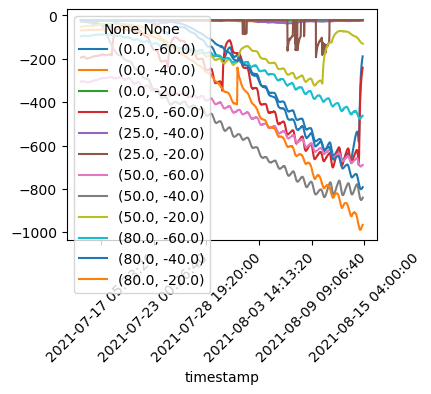

In [17]:
plot()

Snapshots of sensor data at different timestamps

In [18]:
def plot():
    fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
    for i, timestamp in enumerate([1628950550, 1626309949, 1627101007]):
        df[df["timestamp"] == timestamp].plot.scatter(ax=ax[i], x='xx', y='yy', c='value', cmap='seismic_r', s=100, title=pd.to_datetime(timestamp, unit='s').strftime('%Y-%m-%d %H:%M:%S'))

    fig.tight_layout()

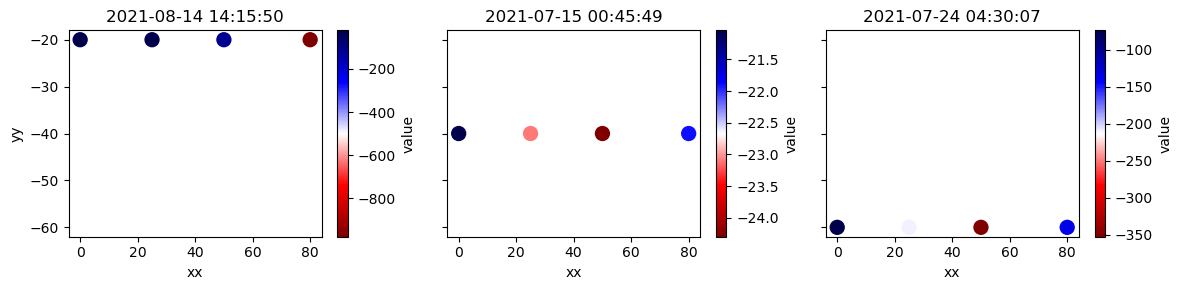

In [19]:
plot()

What if we bin our data hourly?

In [20]:
def plot():
    fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
    for i, timestamp in enumerate([1628950550, 1626309949, 1627101007]):
        df[df["timestamp"].apply(lambda x: int(x / (60 * 60))) == int(timestamp / (60 * 60))].plot.scatter(ax=ax[i], x='xx', y='yy', c='value', cmap='seismic_r', s=100, title=pd.to_datetime(int(timestamp / (60 * 60)) * 60 * 60, unit='s').strftime('%Y-%m-%d %H:%M:%S'))

    fig.tight_layout()

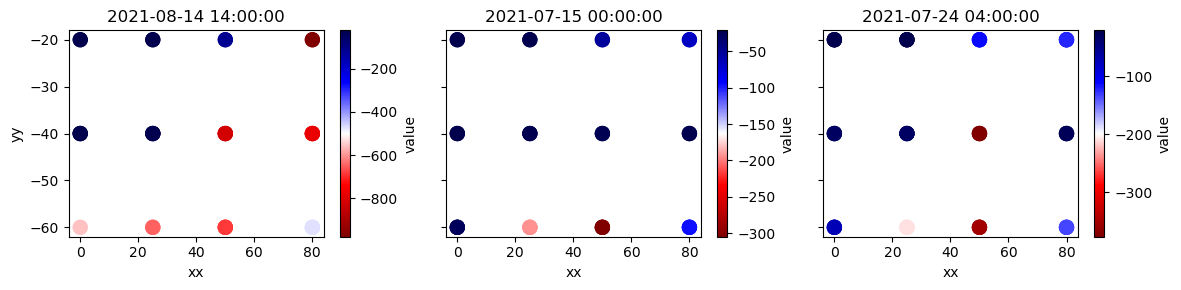

In [21]:
plot()

Data preparation
- Bin data hourly, average the soil moisture for each sensor 
- Create derived attributes (e.g., time/sensor hierarchy) useful for posterior analysis

In [22]:
df["timestamp"] = df["timestamp"].apply(lambda x: int(x / 3600) * 3600)  # bin the time by hours
df1 = df.groupby(["plantRow", "timestamp", "xx", "yy"])["value"].mean().reset_index()  # compute the average humidity
df1["hour"] = [pd.to_datetime(tm, unit='s').strftime('%Y-%m-%d %H') for tm in df1["timestamp"]]  # format the hour
df1["date"] = [pd.to_datetime(tm, unit='s').strftime('%Y-%m-%d') for tm in df1["timestamp"]]  # format the date
df1["month"] = [pd.to_datetime(tm, unit='s').strftime('%Y-%m') for tm in df1["timestamp"]]  # format the month
df1["year"] = [pd.to_datetime(tm, unit='s').strftime('%Y') for tm in df1["timestamp"]]  # format the year
df1["timestamp"] = [pd.to_datetime(tm, unit='s').strftime('%Y-%m-%d %H:%M:%S') for tm in df1["timestamp"]]  # format the timestamp

df2 = df1.copy(deep=True)
df2["sensor"] = df2.apply(lambda x: "(" + str(x["xx"]) + ", " + str(x["yy"]) + ")", axis=1)
df2 = df2.rename({"xx": "dist", "yy": "depth", "plantRow": "plant"}, axis=1)

In [23]:
df1

,plantRow,timestamp,xx,yy,value,hour,date,month,year
0,T1 basso,2021-07-15 00:00:00,0.0,-60.0,-27.366967,2021-07-15 00,2021-07-15,2021-07,2021
1,T1 basso,2021-07-15 00:00:00,0.0,-40.0,-21.041212,2021-07-15 00,2021-07-15,2021-07,2021
2,T1 basso,2021-07-15 00:00:00,0.0,-20.0,-21.041212,2021-07-15 00,2021-07-15,2021-07,2021
3,T1 basso,2021-07-15 00:00:00,25.0,-60.0,-193.593787,2021-07-15 00,2021-07-15,2021-07,2021
4,T1 basso,2021-07-15 00:00:00,25.0,-40.0,-23.102383,2021-07-15 00,2021-07-15,2021-07,2021
...,...,...,...,...,...,...,...,...,...
8751,T1 basso,2021-08-14 23:00:00,50.0,-40.0,-840.353649,2021-08-14 23,2021-08-14,2021-08,2021
8752,T1 basso,2021-08-14 23:00:00,50.0,-20.0,-129.913714,2021-08-14 23,2021-08-14,2021-08,2021
8753,T1 basso,2021-08-14 23:00:00,80.0,-60.0,-462.190096,2021-08-14 23,2021-08-14,2021-08,2021
8754,T1 basso,2021-08-14 23:00:00,80.0,-40.0,-791.964873,2021-08-14 23,2021-08-14,2021-08,2021


In [24]:
df2

,plant,timestamp,dist,depth,value,hour,date,month,year,sensor
0,T1 basso,2021-07-15 00:00:00,0.0,-60.0,-27.366967,2021-07-15 00,2021-07-15,2021-07,2021,"(0.0, -60.0)"
1,T1 basso,2021-07-15 00:00:00,0.0,-40.0,-21.041212,2021-07-15 00,2021-07-15,2021-07,2021,"(0.0, -40.0)"
2,T1 basso,2021-07-15 00:00:00,0.0,-20.0,-21.041212,2021-07-15 00,2021-07-15,2021-07,2021,"(0.0, -20.0)"
3,T1 basso,2021-07-15 00:00:00,25.0,-60.0,-193.593787,2021-07-15 00,2021-07-15,2021-07,2021,"(25.0, -60.0)"
4,T1 basso,2021-07-15 00:00:00,25.0,-40.0,-23.102383,2021-07-15 00,2021-07-15,2021-07,2021,"(25.0, -40.0)"
...,...,...,...,...,...,...,...,...,...,...
8751,T1 basso,2021-08-14 23:00:00,50.0,-40.0,-840.353649,2021-08-14 23,2021-08-14,2021-08,2021,"(50.0, -40.0)"
8752,T1 basso,2021-08-14 23:00:00,50.0,-20.0,-129.913714,2021-08-14 23,2021-08-14,2021-08,2021,"(50.0, -20.0)"
8753,T1 basso,2021-08-14 23:00:00,80.0,-60.0,-462.190096,2021-08-14 23,2021-08-14,2021-08,2021,"(80.0, -60.0)"
8754,T1 basso,2021-08-14 23:00:00,80.0,-40.0,-791.964873,2021-08-14 23,2021-08-14,2021-08,2021,"(80.0, -40.0)"


Finally, save the data back to S3.

In [25]:
# wr.s3.to_csv(df=df1, path=output_bucket + "cleaned-v1-" + file_name, index=False)

In [26]:
wr.s3.to_csv(df=df2, path=output_bucket + "cleaned-v2-" + file_name, index=False)

{'paths': ['s3://staging-clean-wateringsensors-12345/cleaned-v2-watering-data-1661269649253.csv'],
 'partitions_values': {}}

In [27]:
databases = wr.catalog.databases()
databases

,Database,Description


In [28]:
df_tables = wr.catalog.tables()
df_tables

,Database,Table,Description,TableType,Columns,Partitions


In [29]:
pdf = df2[["sensor", "value", "timestamp"]].pivot(index='timestamp', columns='sensor')
pdf.columns = pdf.columns.droplevel(0)
pdf = pdf.reset_index().rename_axis(None, axis=1)
pdf

,timestamp,"(0.0, -20.0)","(0.0, -40.0)","(0.0, -60.0)","(25.0, -20.0)","(25.0, -40.0)","(25.0, -60.0)","(50.0, -20.0)","(50.0, -40.0)","(50.0, -60.0)","(80.0, -20.0)","(80.0, -40.0)","(80.0, -60.0)"
0,2021-07-15 00:00:00,-21.041212,-21.041212,-27.366967,-21.616472,-23.102383,-193.593787,-52.528144,-24.204667,-304.915914,-68.562192,-22.095825,-96.347607
1,2021-07-15 01:00:00,-21.041212,-21.041212,-27.534631,-21.760280,-23.102383,-192.983111,-52.026595,-24.412328,-304.637871,-68.562192,-21.904088,-95.634768
2,2021-07-15 02:00:00,-21.041212,-21.041212,-27.702294,-22.047891,-23.102383,-192.125734,-51.692214,-24.635959,-303.989075,-68.562192,-21.904088,-95.028808
3,2021-07-15 03:00:00,-21.041212,-21.041212,-27.702294,-21.904088,-23.102383,-191.636330,-51.190619,-24.635959,-303.649208,-68.228455,-21.904088,-94.616890
4,2021-07-15 04:00:00,-21.041212,-21.041212,-27.989708,-21.616472,-23.102383,-190.739660,-50.903980,-24.923474,-303.154831,-68.228455,-21.904088,-93.876178
...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,2021-08-14 19:00:00,-20.753568,-22.191694,-256.039903,-21.041212,-23.725431,-306.917177,-125.565894,-850.129532,-695.245247,-981.683056,-800.636272,-470.650216
740,2021-08-14 20:00:00,-20.753568,-21.975989,-232.675216,-21.041212,-23.557690,-285.590873,-126.599786,-849.870933,-693.901787,-977.351484,-799.489618,-467.938392
741,2021-08-14 21:00:00,-20.753568,-21.904088,-214.867884,-21.041212,-23.389949,-268.375038,-127.830821,-847.995784,-692.062365,-973.500444,-797.590173,-465.339106
742,2021-08-14 22:00:00,-20.753568,-21.904088,-201.340064,-21.041212,-23.389949,-254.095873,-129.053794,-845.106682,-690.134413,-968.902449,-795.092987,-463.250007


In [30]:
# import seaborn as sns
# sns.pairplot(pdf)
# plt.show()

In [31]:
# wr.s3.to_csv(df=pdf, path=output_bucket + "/pivot.csv", index=False)

## 4. Build a (relational) data warehouse (AWS RDS)

Amazon Relational Database Service (Amazon RDS) 
- A collection of managed services that makes it simple to set up, operate, and scale relational databases in the cloud


![image](https://user-images.githubusercontent.com/18005592/200369753-f6d9e73e-6d7f-4d4b-bad6-311528e51629.png)

![image](https://github.com/w4bo/welaser/assets/18005592/ec3cdca6-548f-4370-95ca-107fcbb215ed)

In [32]:
pwd = "bigdata2023"

![image](https://user-images.githubusercontent.com/18005592/200370529-ae695d6f-9629-49bb-ae13-a4f5caeb9a0d.png)

![image](https://user-images.githubusercontent.com/18005592/200373378-f257ef56-aea9-4eb3-a922-2a4a3b2a1d11.png)

By default, even if you have set "Public accessibility" to "Yes", the "Security Group" is still not allowing external connections yet.

- Virtual private clouds (VPC): a VPC is a virtual network that closely resembles a traditional network that you'd operate in your own data center
- A security group acts as a virtual firewall for your AWS instances to control incoming/outgoing traffic
    - When you launch an instance, you can specify one or more security groups
    - If you don't specify a security group, Amazon EC2 uses the default security group
- Your AWS account automatically has a default security group for the default VPC in each Region

From [Default security groups (2022-11-15)](https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/default-custom-security-groups.html#default-security-group)

![image](https://user-images.githubusercontent.com/18005592/201981163-0bd75761-be85-41ea-aaf9-6af66e3e41ac.png)


You can add or remove inbound and outbound rules for any default security group.

![image](https://user-images.githubusercontent.com/18005592/201690868-abdd53f7-c6b5-48d4-89ce-e9f6f374a8ce.png)


![image](https://user-images.githubusercontent.com/18005592/201691253-db130df8-c31a-4c6f-aa69-34cf4d89f0e2.png)

![image](https://user-images.githubusercontent.com/18005592/201691398-a16f467e-c6cd-4dd9-8fc3-f31b45740ec4.png)

Which is the schema of our dataset?

In [33]:
df2.columns

Index(['plant', 'timestamp', 'dist', 'depth', 'value', 'hour', 'date', 'month',
       'year', 'sensor'],
      dtype='object')

In [34]:
raw_data = wr.s3.read_csv(output_bucket + "cleaned-v2-" + file_name)
raw_data

,plant,timestamp,dist,depth,value,hour,date,month,year,sensor
0,T1 basso,2021-07-15 00:00:00,0.0,-60.0,-27.366967,2021-07-15 00,2021-07-15,2021-07,2021,"(0.0, -60.0)"
1,T1 basso,2021-07-15 00:00:00,0.0,-40.0,-21.041212,2021-07-15 00,2021-07-15,2021-07,2021,"(0.0, -40.0)"
2,T1 basso,2021-07-15 00:00:00,0.0,-20.0,-21.041212,2021-07-15 00,2021-07-15,2021-07,2021,"(0.0, -20.0)"
3,T1 basso,2021-07-15 00:00:00,25.0,-60.0,-193.593787,2021-07-15 00,2021-07-15,2021-07,2021,"(25.0, -60.0)"
4,T1 basso,2021-07-15 00:00:00,25.0,-40.0,-23.102383,2021-07-15 00,2021-07-15,2021-07,2021,"(25.0, -40.0)"
...,...,...,...,...,...,...,...,...,...,...
8751,T1 basso,2021-08-14 23:00:00,50.0,-40.0,-840.353649,2021-08-14 23,2021-08-14,2021-08,2021,"(50.0, -40.0)"
8752,T1 basso,2021-08-14 23:00:00,50.0,-20.0,-129.913714,2021-08-14 23,2021-08-14,2021-08,2021,"(50.0, -20.0)"
8753,T1 basso,2021-08-14 23:00:00,80.0,-60.0,-462.190096,2021-08-14 23,2021-08-14,2021-08,2021,"(80.0, -60.0)"
8754,T1 basso,2021-08-14 23:00:00,80.0,-40.0,-791.964873,2021-08-14 23,2021-08-14,2021-08,2021,"(80.0, -40.0)"


- Is this schema normalized?
- Is this the schema you are used to when building DWH?

We need to distinguish the fact and the dimension tables:
- FT: Measurement
- DT1: Time
- DT2: Sensor

In [35]:
dt_time = raw_data[["timestamp", "date", "month", "year"]].drop_duplicates()
dt_time

,timestamp,date,month,year
0,2021-07-15 00:00:00,2021-07-15,2021-07,2021
12,2021-07-15 01:00:00,2021-07-15,2021-07,2021
24,2021-07-15 02:00:00,2021-07-15,2021-07,2021
36,2021-07-15 03:00:00,2021-07-15,2021-07,2021
48,2021-07-15 04:00:00,2021-07-15,2021-07,2021
...,...,...,...,...
8696,2021-08-14 19:00:00,2021-08-14,2021-08,2021
8708,2021-08-14 20:00:00,2021-08-14,2021-08,2021
8720,2021-08-14 21:00:00,2021-08-14,2021-08,2021
8732,2021-08-14 22:00:00,2021-08-14,2021-08,2021


In [36]:
dt_sensor = raw_data[["sensor", "dist", "depth", "plant"]].drop_duplicates()
dt_sensor

,sensor,dist,depth,plant
0,"(0.0, -60.0)",0.0,-60.0,T1 basso
1,"(0.0, -40.0)",0.0,-40.0,T1 basso
2,"(0.0, -20.0)",0.0,-20.0,T1 basso
3,"(25.0, -60.0)",25.0,-60.0,T1 basso
4,"(25.0, -40.0)",25.0,-40.0,T1 basso
5,"(25.0, -20.0)",25.0,-20.0,T1 basso
6,"(50.0, -60.0)",50.0,-60.0,T1 basso
7,"(50.0, -40.0)",50.0,-40.0,T1 basso
8,"(50.0, -20.0)",50.0,-20.0,T1 basso
9,"(80.0, -60.0)",80.0,-60.0,T1 basso


In [37]:
ft_mea = raw_data[["sensor", "timestamp", "value"]].drop_duplicates()
ft_mea

,sensor,timestamp,value
0,"(0.0, -60.0)",2021-07-15 00:00:00,-27.366967
1,"(0.0, -40.0)",2021-07-15 00:00:00,-21.041212
2,"(0.0, -20.0)",2021-07-15 00:00:00,-21.041212
3,"(25.0, -60.0)",2021-07-15 00:00:00,-193.593787
4,"(25.0, -40.0)",2021-07-15 00:00:00,-23.102383
...,...,...,...
8751,"(50.0, -40.0)",2021-08-14 23:00:00,-840.353649
8752,"(50.0, -20.0)",2021-08-14 23:00:00,-129.913714
8753,"(80.0, -60.0)",2021-08-14 23:00:00,-462.190096
8754,"(80.0, -40.0)",2021-08-14 23:00:00,-791.964873


We need to connect to the database...

![image](https://user-images.githubusercontent.com/18005592/200372868-4881edde-4f7f-4024-8ffb-cc3836d1a367.png)

In [38]:
host = "sensor-dwh1.crxqb7bplkfq.us-east-1.rds.amazonaws.com"
port = 5432
user = "postgres"
db = "postgres"

from sqlalchemy import create_engine
s = 'postgresql://{}:{}@{}:{}/{}'.format(user, pwd, host, str(port), db)
engine = create_engine(s)

... and just write the tables

In [39]:
dt_sensor.to_sql('sensor', engine, index=False, if_exists='replace')

12

In [40]:
dt_time.to_sql('date', engine, index=False, if_exists='replace')

744

In [41]:
ft_mea.to_sql('measurement', engine, index=False, if_exists='replace')

756

## 5. Query the data warehouse (Tableau)

![image](https://user-images.githubusercontent.com/18005592/200375443-c023c9f7-6df4-4717-91a6-4d9ea230eaea.png)

Tasks

1. Build the hierarchies by following the functional dependencies
2. Plot the average soil moisture (`avg(value)`) by `sensor` and `date`. Is soil moisture behaving as expected for all sensors?
3. Plot the standard deviation of the soil moisture for every sensor. What can you tell from this visualization?